# Analysis of Benchmarking Results for LSMTree

In [1]:
import os.path
import json
from glob import glob
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns

plt.style.use(['fivethirtyeight'])
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

colors = [c['color'] for c in plt.rcParams['axes.prop_cycle']]

## Load and Preprocess Data

In [33]:
paths = glob('../dbf0java/benchmarks/disk_key_value/lsm/*.jsonl')
paths

['../dbf0java/benchmarks/disk_key_value/lsm/job5_results.jsonl',
 '../dbf0java/benchmarks/disk_key_value/lsm/job4_results.jsonl',
 '../dbf0java/benchmarks/disk_key_value/lsm/job2_results.jsonl',
 '../dbf0java/benchmarks/disk_key_value/lsm/job7_results.jsonl',
 '../dbf0java/benchmarks/disk_key_value/lsm/job1_results.jsonl',
 '../dbf0java/benchmarks/disk_key_value/lsm/job6_results.jsonl',
 '../dbf0java/benchmarks/disk_key_value/lsm/job3_results.jsonl',
 '../dbf0java/benchmarks/disk_key_value/lsm/job0_results.jsonl']

In [82]:
duration_seconds = 60 * 60
op_cols = ['put', 'delete', 'get']
found_cols = ['get_found', 'delete_found']
constant_cols = ['value_length', 'base_index_rate']

results = []
for path in paths:
    with open(path, 'rt') as fp:
        for line in fp:
            spec, counts = json.loads(line)
            spec.update(counts)
            results.append(spec)

results = pd.DataFrame(results)

results = results.rename(columns={
    'getFound': 'get_found',
    'fileSize': 'data_size',
    'put_del_get': 'workload'
})

results = results[results['seconds'] == duration_seconds].drop('seconds', axis=1)
results['write_delta_threshold'] = results['pending_write_merge_threshold'] // int(1e5)
results['key_space_size'] = results['key_length'] // int(1e6)
results['known_key_rate'] = (results['known_key_rate'] * 100).astype(int)
results = results.drop(['key_length', 'deleteFound', 'type', 'pending_write_merge_threshold'], axis=1)

# early results incorrectly reported file size as just the directory entry size 
results.loc[results['data_size'] < 1e6, 'data_size'] = np.nan
results['data_size'] = (results['data_size'] / 1e9).round(1)


for col in constant_cols:
    assert results[col].nunique() == 1, f'{col} is not constant'
results = results.drop(constant_cols, axis=1)

print(len(results))
results.sample(5).T

154


,115,112,123,68,44
workload,PUT_HEAVY,PUT_HEAVY,GET_HEAVY,GET_HEAVY,BALANCED
known_key_rate,50,90,10,90,90
thread_count,64,4,16,4,4
trial_index,8,9,4,7,6
put,177538737,164166429,33739413,60320663,60472451
delete,9861065,9117451,16871145,30156958,60468925
get,9864372,9114963,286750695,512761629,62309322
get_found,2132995,758369,149999339,17695176,491256
data_size,264,120.7,7,77.2,112.9
write_delta_threshold,10,1,10,10,1


In [83]:
col_description = {
    'put_del_get': 'Workload',
    'known_key_rate': 'Key Find Rate (%)',
    'thread_count': 'Threads',
    'write_delta_threshold': 'Write Delta Threshold (100,000s)',
    'key_space_size': 'Key Space Size (Millions)',
    'workload': 'Workload'
}

## Analysis of Final Data Size
(Sum of All Files for a Store)

In [40]:
results.sort_values('data_size', ascending=False).head(5).T

,89,115,122,64,45
workload,PUT_HEAVY,PUT_HEAVY,PUT_HEAVY,PUT_HEAVY,PUT_HEAVY
known_key_rate,0.9,0.5,0.9,0.9,0.9
thread_count,64,64,4,16,16
trial_index,1,8,9,7,4
put,225564193,177538737,284667295,119412486,318927728
delete,12533594,9861065,15810929,6633426,17718651
get,12532966,9864372,15816743,6631303,17713556
get_found,2429113,2132995,1420780,723973,2505429
data_size,356.1,264,226.5,196,179.3
write_delta_threshold,1,1,1,0,1


# Aggregate across different trials for same parameter combinations
Note, most scenarios should only have one trial

In [84]:
index_cols = [c for c in results.columns if c not in (op_cols + found_cols + [
    'base_index_rate', 'type', 'trial_index', 'data_size'])]
x = results.copy()
for col in op_cols:
    x[col] = (x[col] / duration_seconds / 1000).round(2).astype(float)
x['sum'] = x[op_cols].sum(axis=1).round(2)
y = x
agg_cols = op_cols + ['sum', 'data_size']
for col in op_cols + ['sum']:
    y[col] = y[col].astype(float)
y = y.groupby([c for c in index_cols if c in y.columns])[agg_cols].describe()
y = y.drop([(col, stat) for col in agg_cols for stat in ['std', 'mean']], axis=1)
norm_agg = y
norm_agg.sample(5).T

workload              PUT_HEAVY         GET_HEAVY DELETE_HEAVY BALANCED
known_key_rate               50      10        50           50       10
thread_count                 64      64        4            16       1 
write_delta_threshold         1       1         1            1        1
key_space_size             1000    1000      10           100      10  
put       count            1.00    1.00      1.00         1.00    3.000
          min             22.61   21.29      4.99        17.24    7.010
          25%             22.61   21.29      4.99        17.24    7.035
          50%             22.61   21.29      4.99        17.24    7.060
          75%             22.61   21.29      4.99        17.24    7.415
          max             22.61   21.29      4.99        17.24    7.770
delete    count            1.00    1.00      1.00         1.00    3.000
          min              1.26    1.18      2.49        17.24    7.020
          25%              1.26    1.18      2.49        17.24    7.035
          50%              1.26    1.18      2.49        17.24    7.050
          75%              1.26    1.18      2.49        17.24    7.405
          max              1.26    1.18      2.49        17.24    7.760
get       count            1.00    1.00      1.00         1.00    3.000
          min              1.26    1.18     42.38         3.83    7.230
          25%              1.26    1.18     42.38         3.83    7.250
          50%              1.26    1.18     42.38         3.83    7.270
          75%              1.26    1.18     42.38         3.83    7.635
          max              1.26    1.18     42.38         3.83    8.000
sum       count            1.00    1.00      1.00         1.00    3.000
          min             25.13   23.65     49.86        38.31   21.260
          25%             25.13   23.65     49.86        38.31   21.320
          50%             25.13   23.65     49.86        38.31   21.380
          75%             25.13   23.65     49.86        38.31   22.455
          max             25.13   23.65     49.86        38.31   23.530
data_size count            0.00    1.00      0.00         1.00    2.000
          min               NaN  136.70       NaN        74.20    6.700
          25%               NaN  136.70       NaN        74.20    6.725
          50%               NaN  136.70       NaN        74.20    6.750
          75%               NaN  136.70       NaN        74.20    6.775
          max               NaN  136.70       NaN        74.20    6.800

In [87]:
agg_median = pd.concat([norm_agg[col]['50%'].rename(col) for col in op_cols + ['data_size','sum']], axis=1)
agg_median = agg_median.sort_values('sum', ascending=False)
agg_median.sample(5)

put  \
workload     known_key_rate thread_count write_delta_threshold key_space_size          
BALANCED     10             16           1                     10              12.76   
             90             1            10                    1000            21.31   
DELETE_HEAVY 10             1            10                    10              40.73   
GET_HEAVY    10             64           10                    10               9.19   
DELETE_HEAVY 90             16           10                    1000            51.97   

                                                                               delete  \
workload     known_key_rate thread_count write_delta_threshold key_space_size           
BALANCED     10             16           1                     10               12.75   
             90             1            10                    1000             21.31   
DELETE_HEAVY 10             1            10                    10               40.73   
GET_HEAVY    10             64           10                    10                4.59   
DELETE_HEAVY 90             16           10                    1000             51.97   

                                                                                 get  \
workload     known_key_rate thread_count write_delta_threshold key_space_size          
BALANCED     10             16           1                     10              13.14   
             90             1            10                    1000            21.95   
DELETE_HEAVY 10             1            10                    10               9.05   
GET_HEAVY    10             64           10                    10              78.12   
DELETE_HEAVY 90             16           10                    1000            11.55   

                                                                               data_size  \
workload     known_key_rate thread_count write_delta_threshold key_space_size              
BALANCED     10             16           1                     10                    5.8   
             90             1            10                    1000                 78.8   
DELETE_HEAVY 10             1            10                    10                   10.6   
GET_HEAVY    10             64           10                    10                    NaN   
DELETE_HEAVY 90             16           10                    1000                  NaN   

                                                                                  sum  
workload     known_key_rate thread_count write_delta_threshold key_space_size          
BALANCED     10             16           1                     10               38.65  
             90             1            10                    1000             64.57  
DELETE_HEAVY 10             1            10                    10               90.51  
GET_HEAVY    10             64           10                    10               91.90  
DELETE_HEAVY 90             16           10                    1000            115.49

# Investigate the top and bottom performing scenarios

In [89]:
x = agg_median.copy()

x = x.rename_axis(index=col_description)
x = x.rename(columns={c:c.capitalize() for c in x.columns})
x = pd.concat({'Operations per a Second (Thousands)': x[['Put', 'Delete', 'Get', 'Sum']],
               'Final Data Size (GB)': x['Data_size'].rename('')}, axis=1)
x = x.dropna()
x = x.rename(columns={'':'x'})
x = x.reset_index(col_level=1)
x = x.rename(columns={'':'Benchmarking Scenario'})
x = x.rename(columns={'x':''})

top = pd.concat({'Top Performing Scenarios': x.head()}, axis=1)
display(top)

low = pd.concat({'Lowest Performing Scenarios': x.tail()}, axis=1)
display(low.tail())

print(' '.join(top.to_html(index=False).split()))
print()
print(' '.join(low.to_html(index=False).split()))


Top Performing Scenarios                            \
     Benchmarking Scenario                             
                  Workload Key Find Rate (%) Threads   
0                GET_HEAVY                90       4   
1             DELETE_HEAVY                90       4   
2                PUT_HEAVY                50       4   
3                GET_HEAVY                90       1   
4                 BALANCED                90      16   

                                                              \
                                                               
  Write Delta Threshold (100,000s) Key Space Size (Millions)   
0                               10                        10   
1                               10                        10   
2                               10                        10   
3                               10                        10   
4                               10                        10   

                                                                 \
  Operations per a Second (Thousands)                             
                                  Put   Delete      Get     Sum   
0                               32.85   16.420  279.170  328.44   
1                              143.41  143.410   31.870  318.69   
2                              183.30   10.185   10.185  203.67   
3                               18.70    9.350  158.970  187.02   
4                               57.29   57.300   59.040  173.63   

                        
  Final Data Size (GB)  
                        
0                 16.3  
1                 21.9  
2                 23.8  
3                  9.9  
4                 10.1

Lowest Performing Scenarios                            \
         Benchmarking Scenario                             
                      Workload Key Find Rate (%) Threads   
82                   GET_HEAVY                10       1   
83                   PUT_HEAVY                10       1   
84                DELETE_HEAVY                10       1   
85                    BALANCED                10      64   
86                    BALANCED                10       1   

                                                               \
                                                                
   Write Delta Threshold (100,000s) Key Space Size (Millions)   
82                                1                      1000   
83                                1                       100   
84                                1                      1000   
85                                1                      1000   
86                                1                       100   

                                                               \
   Operations per a Second (Thousands)                          
                                   Put Delete     Get     Sum   
82                                2.11   1.06  17.960  21.130   
83                               18.47   1.03   1.030  20.530   
84                                9.23   9.23   2.050  20.510   
85                                6.63   6.63   6.830  20.090   
86                                5.78   5.78   5.955  17.515   

                         
   Final Data Size (GB)  
                         
82                  7.8  
83                 81.4  
84                 49.8  
85                 32.5  
86                 22.8

<table border="1" class="dataframe"> <thead> <tr> <th colspan="10" halign="left">Top Performing Scenarios</th> </tr> <tr> <th colspan="5" halign="left">Benchmarking Scenario</th> <th colspan="4" halign="left">Operations per a Second (Thousands)</th> <th>Final Data Size (GB)</th> </tr> <tr> <th>Workload</th> <th>Key Find Rate (%)</th> <th>Threads</th> <th>Write Delta Threshold (100,000s)</th> <th>Key Space Size (Millions)</th> <th>Put</th> <th>Delete</th> <th>Get</th> <th>Sum</th> <th></th> </tr> </thead> <tbody> <tr> <td>GET_HEAVY</td> <td>90</td> <td>4</td> <td>10</td> <td>10</td> <td>32.85</td> <td>16.420</td> <td>279.170</td> <td>328.44</td> <td>16.3</td> </tr> <tr> <td>DELETE_HEAVY</td> <td>90</td> <td>4</td> <td>10</td> <td>10</td> <td>143.41</td> <td>143.410</td> <td>31.870</td> <td>318.69</td> <td>21.9</td> </tr> <tr> <td>PUT_HEAVY</td> <td>50</td> <td>4</td> <td>10</td> <td>10</td> <td>183.30</td> <td>10.185</td> <td>10.185</td> <td>203.67</td> <td>23.8</td> </tr> <tr> <td>GET_

# Impact of File Size and Relation to Key Space Size

,count,mean,std,min,25%,50%,75%,max
key_space_size,,,,,,,,
10,40.0,12.480000,5.811933,5.5,7.65,10.45,16.225,26.6
100,30.0,84.430000,60.922037,14.6,31.15,75.70,131.800,226.5
1000,34.0,95.908824,74.815925,7.8,47.55,73.10,130.750,356.1


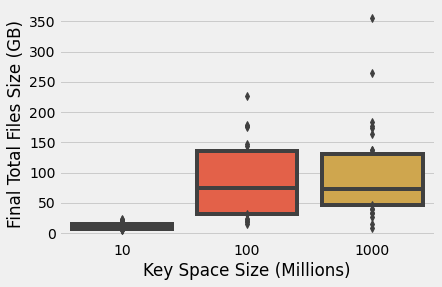

In [134]:
x = norm_agg['data_size']['50%'].rename('data_size').reset_index()
sns.boxplot(data=x, y='data_size', x='key_space_size', whis=0)
plt.ylabel('Final Total Files Size (GB)')
plt.xlabel('Key Space Size (Millions)')
plt.savefig(figdir + '/key_space_final_size.png', bbox_inches='tight')
results.groupby('key_space_size')['data_size'].describe()

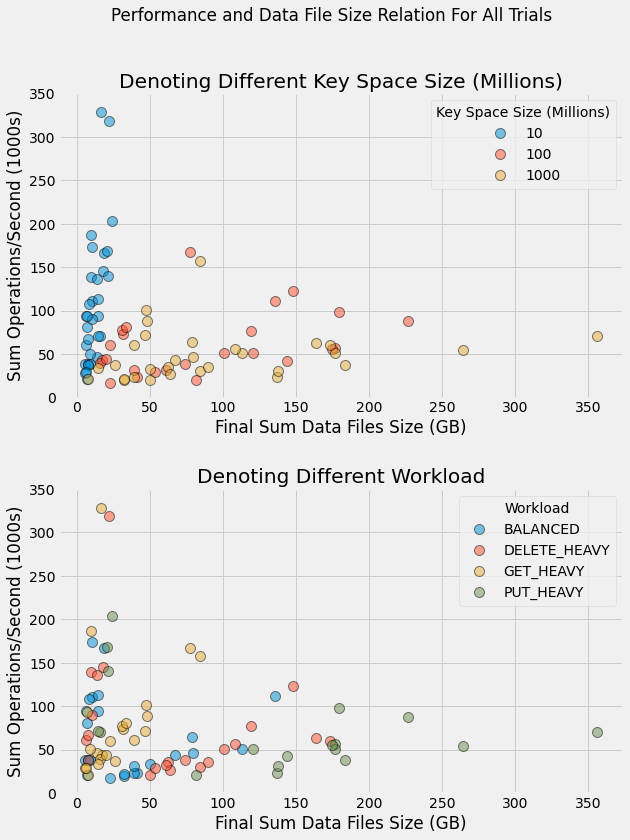

In [152]:
f = norm_agg['data_size']['50%'].rename('data_size')
s = norm_agg['sum']['50%'].rename('sum')
x = pd.concat([f, s], axis=1).loc[~np.isnan(f)]

fig = plt.figure(figsize=(9,12))
fig.subplots_adjust(hspace=0.3)
fig.suptitle('Performance and Data File Size Relation For All Trials')

for i, (gb_col, desc) in enumerate([
    ['key_space_size', 'Key Space Size (Millions)'],
    ['workload', 'Workload']
                                    ]):
    ax = fig.add_subplot(2, 1, i+1)
    for workload,y in x.groupby(gb_col):
        ax.plot(y['data_size'], y['sum'], 'o', label=workload, ms=10, alpha=0.5, mew=1, mec='k')
    plt.legend(loc='upper right', title=desc)
    plt.xlabel('Final Sum Data Files Size (GB)')
    plt.ylabel('Sum Operations/Second (1000s)')
    plt.title('Denoting Different ' + desc)
    plt.ylim(0, 350)

plt.savefig(figdir + '/file_size_sum_ops_relation.png', bbox_inches='tight')

# Impact of Individual Parameters on Performance

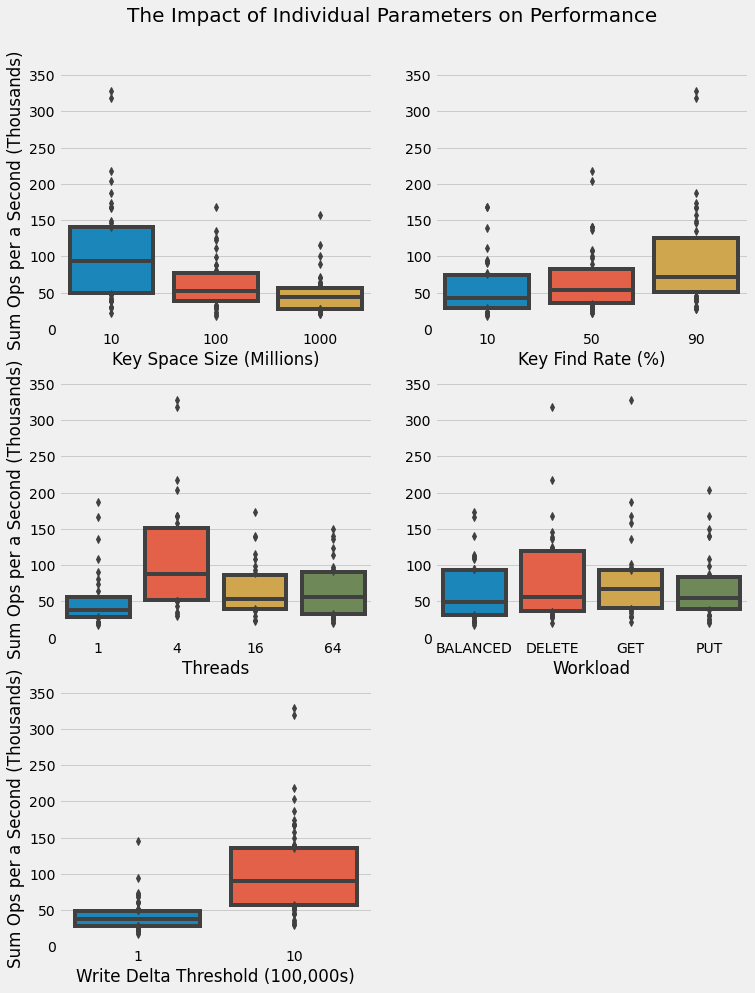

In [163]:
fig = plt.figure(figsize=(11,15))
x = norm_agg['sum'].copy()
cols = sorted(set(x.index.names) -
              {'key_length', 'type', 'parent_capacity', 'leaf_capacity', 'vacuum_threshold', 'base_index_rate',
              'file_size', 'value_length'})
x = x.reset_index()
x['workload'] = x['workload'].str.replace('_HEAVY', '')
for i,col in enumerate(cols):
    ax = fig.add_subplot(3, 2, i + 1)
    sns.boxplot(ax=ax, x=col, y="50%",
                  data=x,
                  whis=0)
    plt.ylim(0, 355)
    plt.ylabel('Sum Ops per a Second (Thousands)' if i%2==0 else '')
    plt.xlabel(col_description[col])
fig.subplots_adjust(hspace=0.2)
fig.suptitle('The Impact of Individual Parameters on Performance', y=0.94, size=20)
    
plt.savefig(figdir + '/benchmarking_indv_param.png', bbox_inches='tight')

## Materials for Project Page

In [109]:
import re

workloads = '''
PUT_HEAVY(0.9, 0.05)
GET_HEAVY(0.1, 0.05)
DELETE_HEAVY(0.45, 0.45)
BALANCED(0.33, 0.33)
'''

workloads = re.findall(r'([A-Z_]+)\(([\d.]+),\s+([\d.]+)', workloads)
workloads = pd.DataFrame(workloads, columns=['Workload', 'Put', 'Delete'])
workloads['Put'] = workloads['Put'].astype(float).mul(100).astype(int)
workloads['Delete'] = workloads['Delete'].astype(float).mul(100).astype(int)
workloads['Get'] = 100 - workloads['Put'] - workloads['Delete']
workloads = pd.concat({'Operation Frequency (%)':workloads.set_index('Workload')}, axis=1)
workloads = workloads.reset_index()
workloads = workloads.rename(columns={'Workload':'x'}).rename(columns={'':'Workload'}).rename(columns={'x':''})


display(workloads)

print(' '.join(workloads.to_html(index=False).split()))


Operation Frequency (%)           
       Workload                     Put Delete Get
0     PUT_HEAVY                      90      5   5
1     GET_HEAVY                      10      5  85
2  DELETE_HEAVY                      45     45  10
3      BALANCED                      33     33  34

<table border="1" class="dataframe"> <thead> <tr> <th></th> <th colspan="3" halign="left">Operation Frequency (%)</th> </tr> <tr> <th>Workload</th> <th>Put</th> <th>Delete</th> <th>Get</th> </tr> </thead> <tbody> <tr> <td>PUT_HEAVY</td> <td>90</td> <td>5</td> <td>5</td> </tr> <tr> <td>GET_HEAVY</td> <td>10</td> <td>5</td> <td>85</td> </tr> <tr> <td>DELETE_HEAVY</td> <td>45</td> <td>45</td> <td>10</td> </tr> <tr> <td>BALANCED</td> <td>33</td> <td>33</td> <td>34</td> </tr> </tbody> </table>
